## Gaussian Process Example with Matern52 kernel

In [1]:
import sys
import time
import random as rnd
import time

import numpy as np 
import matplotlib.pyplot as plt 

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from jax import random
import jax.numpy as jnp

# PyTorch
import torch
import torch.utils.data as data

# print versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.losses import kl_divergence, scaled_sum_squared_loss
from priorCVAE.utility import create_data_loaders
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import MGPDataset

import jax.config as config
config.update("jax_enable_x64", True)

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.13
Flax version:     0.6.11
Optax version:    0.1.5
Pythorch version: 3.10.0


### Set Arguments

In [2]:
args = {"seed": 0,
        
        # data
        "num_data": 4000,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1,     # what is this parameter?

        # MCMC inference
        "true_ls": 0.2,    # is this a parameter for length scale?
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,    # thin=1 is the default value, keeping all values
       }

### Generate Data

In [3]:
# 1d GP with Matern52 kernel
train_set = MGPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
val_set   = MGPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
test_set  = MGPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])
# creates batched data
# train the `train_set` but not the other two

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

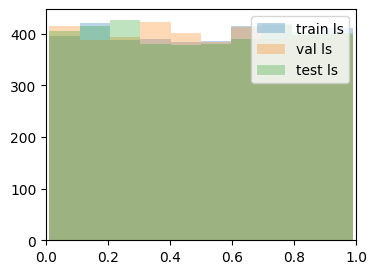

In [4]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set[:, 0],   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

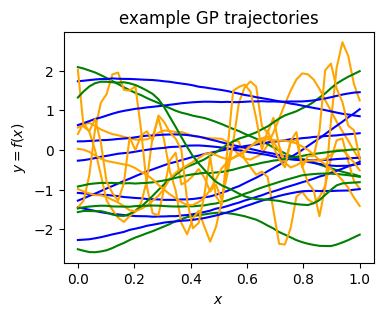

In [6]:
# check: what trajectories are we generating? -- Without constraints

fig, ax = plt.subplots(figsize=(4,3))
for i in range(20):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_data    = args["num_data"] 
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]
vae_var     = args["vae_var"]

### Traing Loop

In [8]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    grads = jax.grad(loss_fn)(state.params, z_rng)
    return state.apply_gradients(grads=grads), loss_fn(state.params, z_rng)

In [9]:
@jax.jit
def eval(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params, z_rng)

In [11]:
# define models
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

# initialise parameters
key = jax.random.PRNGKey(0) 
rng, z_key, eval_key = random.split(key, 3)    # splitting to get new random numbers, understand as diffenrent random seeds

batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(rng, y, key)['params']

# optimizer
# classic Adam optimizer in the `optax` library
optimizer = optax.adam(learning_rate=0.001)    # understand as the size of the gradient descent step

# store training state
# refer to the `train_state` part in FLAX
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

_loss_train = []
_loss_test = []

# start to record time
t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        # since `enumerate()` gives you two loop variables, count and value
        z_key, key = random.split(z_key)
        state, loss_train = train_step(state, batch_train, key)
        # which is the function we defined earlier
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):

        eval_key, key = random.split(eval_key)
        loss_test = eval(state, batch_test, key)
        # which is the function we defined to evaluate loss
        _loss_test.append(loss_test)

    if epoch % 10 == 0:  
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')
        # `5d` is a format for integers, taking 5 spaces
        # `.3f` means only 3 decimal places

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_data // batch_size


[    1] training loss: 2759.833, test loss: 2606.605
[   11] training loss: 1287.974, test loss: 1254.957
[   21] training loss: 979.809, test loss: 1022.117
[   31] training loss: 778.393, test loss: 977.574
[   41] training loss: 778.688, test loss: 911.004
[   51] training loss: 773.123, test loss: 941.457
[   61] training loss: 751.993, test loss: 899.150
[   71] training loss: 820.335, test loss: 874.363
[   81] training loss: 795.817, test loss: 885.663
[   91] training loss: 783.931, test loss: 880.769
[  101] training loss: 785.640, test loss: 909.207
[  111] training loss: 774.467, test loss: 890.055
[  121] training loss: 751.573, test loss: 874.150
[  131] training loss: 744.836, test loss: 896.306
[  141] training loss: 750.120, test loss: 885.118
[  151] training loss: 809.874, test loss: 876.999
[  161] training loss: 906.063, test loss: 874.155
[  171] training loss: 786.604, test loss: 876.017
[  181] training loss: 701.217, test loss: 866.186
[  191] training loss: 835

### Plot Losses

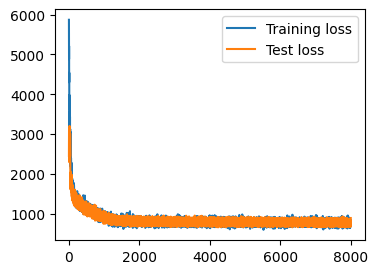

In [12]:
plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

### Plot Learned Priors

(100, 30)
(100, 50)


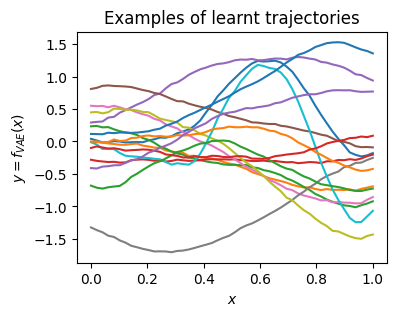

In [13]:
# Get trained decoder params
decoder_params = state.params['decoder']

rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# create decoder
decoder = MLPDecoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
out = decoder.apply({'params': decoder_params}, z)             
print(out.shape)

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

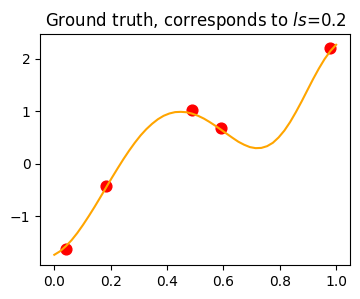

In [18]:
x = train_set[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=args["true_ls"], variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 9, 24, 29, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

In [19]:
# add data to args
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

### Numpyro Model

In [20]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.24      0.25     -1.26     -1.63     -0.83   9235.04      1.00
      f[1]     -1.23      0.24     -1.25     -1.61     -0.84   9971.69      1.00
      f[2]     -1.20      0.23     -1.22     -1.56     -0.82  10886.31      1.00
      f[3]     -1.20      0.24     -1.21     -1.56     -0.81  10431.72      1.00
      f[4]     -1.16      0.23     -1.18     -1.52     -0.78  10833.57      1.00
      f[5]     -1.09      0.22     -1.11     -1.44     -0.74  11568.69      1.00
      f[6]     -1.02      0.19     -1.03     -1.31     -0.70  16013.12      1.00
      f[7]     -0.94      0.17     -0.95     -1.22     -0.65  20259.49      1.00
      f[8]     -0.84      0.17     -0.83     -1.11     -0.56  19993.80      1.00
      f[9]     -0.72      0.18     -0.71     -1.02     -0.42  13963.82      1.00
     f[10]     -0.58      0.22     -0.56     -0.93     -0.23   9639.81      1.00
     f[11]     -0.41      0

### Visual Posterior 

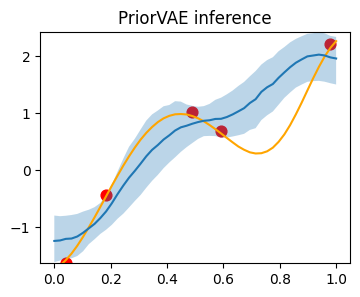

In [22]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')